In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import numpy as np
import os
from PIL import Image

In [30]:
#accquiring the data
val_dir='/content/drive/MyDrive/SigNN Character Database/test'
train_dir='/content/drive/MyDrive/SigNN Character Database/train'

classes=['A','NotA']
train_labels=[]
val_labels=[]
val_data=[]
train_data=[]


for i,dir in enumerate([os.listdir(val_dir),os.listdir(train_dir)]):
  root= val_dir if i == 0 else train_dir
  print(root)
  for category in dir:
    print(category)
    all_dir=os.path.join(root,category)
    for img in os.listdir(all_dir):
    #for validation data
      if i == 0:
        val_data.append(np.array(Image.open(os.path.join(all_dir,img))))
        val_labels.append(0 if category == classes[0] else 1)
    #for training data
      elif i==1:
        train_data.append(np.array(Image.open(os.path.join(all_dir,img))))
        train_labels.append(0 if category == classes[0] else 1)

print(f" There are a total of {len(val_data)} validation images and {len(train_data)} training images")

/content/drive/MyDrive/SigNN Character Database/test
A
NotA
.ipynb_checkpoints
/content/drive/MyDrive/SigNN Character Database/train
A
NotA
.ipynb_checkpoints
 There are a total of 2 validation images and 999 training images


In [31]:
class Preprocessor:
  img_list=[]
  new_size= (0,0)

  def __init__(self,unprocessed_imgs, new_size):
    self.img_list = unprocessed_imgs
    self.new_size= new_size

  def grayscale(self,img):
    #get colour bands
    red_band, green_band, blue_band= img[:, :, 0], img[:, :, 1], img[:, :, 2]
    #Using Luminosity formula...
    grayscaled_img= (0.21 * red_band) + (0.72 * green_band) + (0.07 * blue_band)
    return grayscaled_img

  def resize(self,img):
    new_h , new_w= self.new_size #tuple
    old_h, old_w = img.shape

    # Factors to sacle new image
    row_scale = old_h / new_h
    col_scale = old_w / new_w

    # Initialize resized image array
    resized_img = np.zeros(self.new_size)

     # Iterate over resized image
    for i in range(new_h):
        for j in range(new_w):
            orig_i = int(np.floor(i * row_scale))
            orig_j = int(np.floor(j * col_scale))

            # Assign nearest neighbor pixel value
            resized_img[i, j] = img[orig_i, orig_j]

    return resized_img


  def normalize(self,img):
    normalized_img = np.round(( img/225 ), 2)
    return normalized_img

  def process(self):
    processedImg_list=[]
    for img in self.img_list:
      gray_img= self.grayscale(img)
      resized_img=self.resize(gray_img)
      normalized_img= self.normalize(resized_img)
      processedImg_list.append(normalized_img)

    return processedImg_list

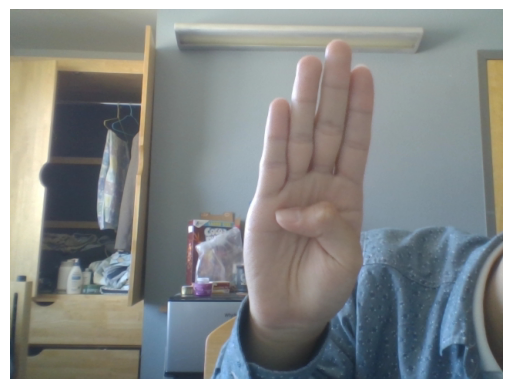

In [32]:
import matplotlib.pyplot as plt
#before pre-processing
plt.imshow(train_data[800])
plt.axis('off')
plt.show()

In [33]:
train_data[800].shape

(480, 640, 3)

In [34]:
#preprocessing
train_preprocessor= Preprocessor(train_data,(224,224)) #for training try flip images for left handed people
train_data=train_preprocessor.process()

val_preprocessor= Preprocessor(val_data,(224,224))
val_data= val_preprocessor.process()

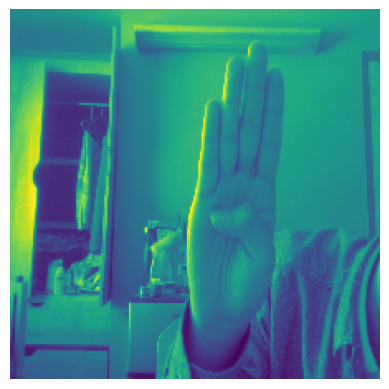

In [35]:
#checking if pr-processing works
plt.imshow(train_data[800])
plt.axis('off')
plt.show()

In [36]:
class flatten_Layer:
  def forward(self,img):
    self.img= img
    self.flat_img=[]

    for row in img:
      for pixel in row:
        self.flat_img.append(pixel)
    return np.array(self.flat_img)

    def back_prop(self,output_grad, lr):
        rows, cols = self.img.shape
        reshaped_img = np.zeros((rows,cols))
        flat_index = 0
        for row in range(rows):
            for col in range(cols):
                reshaped_img[row, col] = self.flat_img[flat_index]
                flat_index += 1
        return reshaped_img

In [37]:
#flatten
flattend=[]
flattener=flatten_Layer()
all_imgs=[]
for img in train_data:
  flattend= flattener.forward(img)
  all_imgs.append(np.array(flattend))

train_data=all_imgs




previous method class activation:

  def tanh(Z):
    return np.tanh(Z)

  def tanh_der(Z): #derivetive of function for back propagation
    return 1 - np.tanh(Z) ** 2

  def sigmoid(x):
    return 1 / (1 + np.exp(-x))

  def sigmoid_der(x):
    sigmoid = 1 / (1 + np.exp(-x))
    return sigmoid(x) * (1 - sigmoid)

  def ReLU(x):
    return np.maximum(0,x)

  def ReLU_der(x):
    return [1 if x > 0 else 0]

  def softmax(Z):
    a = np.exp(Z) / np.sum(np.exp(Z))
    return a

In [38]:

class relu:
    def forward(self, input):
        self.input = input
        activated_values = np.maximum(0, self.input)
        return activated_values

    def back_prop(self, output_grad, lr):
        relu_derivative = np.array([1 if value > 0 else 0 for value in self.input])
        return output_grad * relu_derivative #element wise

class tanh:
    def forward(self, input):
        self.input = input
        self.activated_values = np.tanh(input)
        return self.activated_values

    def back_prop(self, output_grad,lr):
        tanh_derivative = 1 - np.tanh(self.input) ** 2
        return output_grad * tanh_derivative

class sigmoid:
    def forward(self, input):
        self.input = input
        self.activated_values = 1 / (1 + np.exp(-input))
        return self.activated_values

    def back_prop(self, output_grad, lr):
        sigmoid = self.forward(self.input)
        sigmoid_derivative = sigmoid * (1 - sigmoid)
        return output_grad * sigmoid_derivative

class softmax:
    def forward(self, input):
      pass

    def backward(self, output_gradient):
      pass

class dense_Layer:
  def __init__(self, input_neurons, output_neurons):
    #Weight dimentions
    self.weight_matrix=np.random.rand(output_neurons,input_neurons)
    #Bias
    self.bias_vector= np.random.randn(output_neurons)

  def forward(self, input):
    self.input= input
    preact_values= np.dot(self.weight_matrix, input) + self.bias_vector
    return preact_values

  def back_prop(self, preact_grad, learning_rate):
    weight_grad = np.outer(preact_grad, self.input)#calculate outer product
    bias_grad = preact_grad
    input_grad = np.dot(self.weight_matrix.T, preact_grad)

    # Updates
    self.weight_matrix -= weight_grad * learning_rate
    self.bias_vector -= bias_grad * learning_rate

    return input_grad


#IMPLEMENTATION

In [39]:
#Creating model architecture
model= (
    dense_Layer(50176,25088),
    relu(),
    dense_Layer(25088,6272),
    relu(),
    dense_Layer(6272,1568),
    relu(),
    dense_Layer(1568,196),
    relu(),
    dense_Layer(196,1),
    sigmoid())


In [40]:
label_0_indices = [i for i, label in enumerate(train_labels) if label == 0]
label_1_indices = [i for i, label in enumerate(train_labels) if label == 1]

# Select 10 samples of each label
selected_label_0_indices = label_0_indices[:20]
selected_label_1_indices = label_1_indices[:20]

selected_train_data = [train_data[i] for i in selected_label_0_indices + selected_label_1_indices]
selected_train_labels = [train_labels[i] for i in selected_label_0_indices + selected_label_1_indices]


In [ ]:
def binary_cross_entropy_loss(predictions, targets):
    epsilon = 1e-12
    predictions = np.clip(predictions, epsilon, 1. - epsilon) #lower and upper bound clipping
    return -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))

def binary_cross_entropy_grad(predictions, targets):
    epsilon = 1e-12
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    return (predictions - targets) / (predictions * (1 - predictions))


def calculate_accuracy(predictions, targets):
    predicted_classes = predictions > 0.5
    return np.mean(predicted_classes == targets)
#save results to improve specific variations of model
#try using the training set as validation set to know why there is no improvement
#compare images that are vary similar or vary difference
def train_model(model, X_train, y_train, epochs, learning_rate):
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for i in range(len(X_train)):
            # Forward
            input = X_train[i]
            target = y_train[i]
            for layer in model:
                input = layer.forward(input)
            predictions = input

            # Calculate loss
            loss = binary_cross_entropy_loss(predictions, target)
            epoch_loss += loss

            # Back prop
            grad = binary_cross_entropy_grad(predictions, target)
            for layer in reversed(model):
                grad = layer.back_prop(grad, learning_rate)

            # Calculate accuracy
            epoch_accuracy += calculate_accuracy(predictions, target)

        # Average loss and accuracy over the epoch
        epoch_loss /= len(X_train)
        epoch_accuracy /= len(X_train)

        print(f'Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}')


train_model(model, selected_train_data, selected_train_labels, epochs=10, learning_rate=0.01)

Epoch 1/10 - Loss: 13.8155 - Accuracy: 0.5000
Epoch 2/10 - Loss: 13.8155 - Accuracy: 0.5000
Epoch 3/10 - Loss: 13.8155 - Accuracy: 0.5000
Epoch 4/10 - Loss: 13.8155 - Accuracy: 0.5000
Epoch 5/10 - Loss: 13.8155 - Accuracy: 0.5000
Epoch 6/10 - Loss: 13.8155 - Accuracy: 0.5000
Epoch 7/10 - Loss: 13.8155 - Accuracy: 0.5000
Epoch 8/10 - Loss: 13.8155 - Accuracy: 0.5000
Epoch 9/10 - Loss: 13.8155 - Accuracy: 0.5000
Epoch 10/10 - Loss: 13.8155 - Accuracy: 0.5000
